# 1. Imports

In [159]:
from src.configuration import Configuration
from src.fetch_data import DataFetcher
from aggregate_data import DataAggregator
from src.dim import Dims
from src.facts import Facts
from src.dicts import Dicts
import pandas as pd
import numpy as np 
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text



# 2. Variables

In [2]:
config = Configuration('src/config.cfg')
fetcher = DataFetcher(config)
DATAAGGREGATOR = DataAggregator(config, fetcher)
DIMS = Dims(config, fetcher)
DICTS = Dicts(config, fetcher)
FACTS = Facts(config, fetcher)

pd.set_option('display.max_columns', None)

25/11/17 16:15:58 WARN Utils: Your hostname, MacBook-Pro-Grzegorz.local resolves to a loopback address: 127.0.0.1; using 192.168.0.3 instead (on interface en0)
25/11/17 16:15:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/17 16:15:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 49500)
Traceback (most recent call last):
  File "/opt/anaconda3/envs/moje_srodowisko/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/anaconda3/envs/moje_srodowisko/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
  File "/opt/anaconda3/envs/moje_srodowisko/lib/python3.12/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/anaconda3/envs/moje_srodowisko/lib/python3.12/socketserver.py", line 761, in __init__
    self.handle()
  File "/opt/anaconda3/envs/moje_srodowisko/lib/python3.12/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/anaconda3/envs/moje_srodowisko/lib/python3.12/site-packages/pyspark/accumulators.py", line 26

# 3. Data

## 3.1 Driver related data

In [3]:
driver_last_5_races_result = DATAAGGREGATOR.get_last_races_result(5,"Race", "position")
time.sleep(5)
driver_last_5_quali_result = DATAAGGREGATOR.get_last_races_result(5,"Qualifying", "position")
time.sleep(5)
driver_last_5_avg_race_position = DATAAGGREGATOR.get_last_races_result(5, "Race", "avg")
time.sleep(5)
driver_last_5_std_race_position = DATAAGGREGATOR.get_last_races_result(5, "Race", "std")
time.sleep(5)
driver_last_5_avg_quali_position = DATAAGGREGATOR.get_last_races_result(5, "Qualifying", "avg")
time.sleep(5)
driver_last_5_std_quali_position = DATAAGGREGATOR.get_last_races_result(5, "Qualifying", "std")
time.sleep(5)
driver_points_gathered = DATAAGGREGATOR.get_racer_team_points("driver")
time.sleep(10)
driver_gap_to_teammate = DATAAGGREGATOR.calculate_gap_to_teammate()
time.sleep(5)
driver_gap_to_leader = DATAAGGREGATOR.calculate_gap_to_leader()
dict_world_champions = DICTS.dict_world_champions()
time.sleep(10)
pit_stops_efficiency = DATAAGGREGATOR.calculate_pit_stop_efficiency()
time.sleep(10)
driver_race_wins_total = DATAAGGREGATOR.calculate_total_wins("Race")
time.sleep(10)
driver_quali_wins_total = DATAAGGREGATOR.calculate_total_wins("Qualifying")
time.sleep(10)

/Users/grzegorznaporowski/Desktop/Portfolio/F1/aggregate_data.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_filtered["points_gap_to_teammate"] = merged_filtered["points_gained"] - merged_filtered["points_gained_other"]


## 3.2 Team related data

In [4]:
team_points_gathered = DATAAGGREGATOR.get_racer_team_points("team")
time.sleep(5)
team_gap_to_leader = DATAAGGREGATOR.calculate_gap_to_best_team()
time.sleep(10)

## 3.3 Session Related Data

In [5]:
dim_session = DIMS.dim_sessions()
dim_session_race = dim_session[dim_session["session_name"]=="Race"]
needed_cols = ["key", "location", "year", "is_current_season","country_name", "date_start", "session_key"]
dim_session_race = dim_session_race[needed_cols]
race_sequence = DATAAGGREGATOR.calculate_race_sequence_number()

In [6]:
needed_cols = ["driver_number","key","number_of_laps","dnf","dns","dsq","duration"]
fact_session_result = FACTS.fact_session_results()
race_duration = fact_session_result.merge(
    dim_session_race,
    on = "session_key",
    how="inner"
)

race_duration = race_duration[needed_cols]
race_duration["duration"] = race_duration["duration"].fillna(9999)

/var/folders/rd/z4g97_m5135b3yksvpxnxw1m0000gn/T/ipykernel_3624/1971916267.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  race_duration["duration"] = race_duration["duration"].fillna(9999)


## 3.4 Weather Data

In [7]:
dim_session_quali = dim_session[dim_session["session_name"]=="Qualifying"]
needed_cols = ["key", "location", "year", "is_current_season","country_name", "date_start", "session_key"]
dim_session_quali = dim_session_quali[needed_cols]
dim_weather_race = DIMS.dim_weather(race_type="Race")
time.sleep(20)
dim_weather_quali = DIMS.dim_weather(race_type="Qualifying")

### 3.4.1 Race Weather

IMPORTANT NOTE!!!
Treat this data as a weather forecast. Since this data is gathered after the race - we couldn't use to predict a winner of a particular GP. So for sake of this project we will allow this small data leakage.

In [8]:
race_weather = dim_weather_race.merge(
    dim_session_race,
    on="session_key",
    how="inner"
)
cols_race = [col for col in race_weather.columns if "race" in col or col == "key"]
race_weather = race_weather[cols_race]

### 3.5 Qualification Weather

In [ ]:
quali_weather = dim_weather_quali.merge(
    dim_session_quali,
    on="session_key",
    how="inner"
)
cols_quali = [col for col in quali_weather.columns if "quali" in col or col == "key"]
quali_weather = quali_weather[cols_quali]

,wind_direction_qualifying_avg,wind_speed_qualifying_avg,has_rainfall_qualifying,track_temperature_qualifying_avg,air_temperature_qualifying_avg,humidity_qualifying_avg,pressure_qualifying_avg,key
0,213.789474,0.607368,0,28.085263,23.880000,21.652632,1017.641053,Sakhir2023
1,276.762500,1.547500,0,31.666250,27.023750,44.737500,1010.480000,Jeddah2023
2,127.189474,1.322105,1,22.712632,15.204211,53.400000,1018.930526,Melbourne2023
3,175.349057,0.795283,0,33.085849,19.461321,80.622642,1011.652830,Baku2023
4,140.655172,3.437931,0,43.266667,28.644828,59.206897,1017.397701,Miami2023
...,...,...,...,...,...,...,...,...
62,242.064935,2.300000,0,38.670130,26.132468,13.818182,1015.151948,Shanghai2025
63,139.058824,2.984706,0,32.141176,14.695294,58.623529,1013.291765,Suzuka2025
64,22.344828,3.132184,0,30.894253,26.296552,57.114943,1004.088506,Sakhir2025
65,221.662791,0.856977,0,37.225581,29.575581,57.569767,1006.300000,Jeddah2025


## 3.5 Joined Data

In [19]:
df = (
    dim_session
    .merge(driver_last_5_races_result, on="key", how="inner")
    .merge(driver_last_5_quali_result, on=["key", "driver_number"], how="inner", suffixes=["_race", "_quali"])
    .merge(driver_last_5_avg_race_position, on=["driver_number", "key"])
    .merge(driver_last_5_std_race_position, on=["driver_number", "key"])
    .merge(driver_last_5_avg_quali_position, on=["driver_number", "key"])
    .merge(driver_last_5_std_quali_position, on=["driver_number", "key"])
    .merge(driver_points_gathered[["driver_number", "key", "points_gained"]], on=["driver_number", "key"])
    .merge(driver_gap_to_teammate, on=["driver_number", "key"])
    .merge(driver_gap_to_leader, on=["driver_number", "key"])
    .merge(driver_race_wins_total, on = ["driver_number", "key"])
    .merge(driver_quali_wins_total, on = ['driver_number', 'key'])
    .merge(team_points_gathered, on=["driver_number", "key"])
    .merge(team_gap_to_leader, on=["driver_number", "key"])
    .merge(dict_world_champions,on="driver_number",how="left")
    .fillna({"titles_count": 0})
    .assign(world_champion=lambda x: x["titles_count"].astype(int))
    .merge(race_duration, on=["driver_number","key"])
    .merge(pit_stops_efficiency, on=["driver_number","key"])
    .merge(race_weather, on="key")
    .merge(quali_weather, on="key")
    .merge(race_sequence, on="key")
)


In [20]:
df.head()

,session_key,location,date_start,date_end,session_name,country_code,country_name,year,is_current_season,key,driver_number,position_race,last_race_pos_1,last_race_pos_2,last_race_pos_3,last_race_pos_4,last_race_pos_5,position_quali,last_qualifying_pos_1,last_qualifying_pos_2,last_qualifying_pos_3,last_qualifying_pos_4,last_qualifying_pos_5,avg_last_5_race,std_last_5_race,avg_last_5_qualifying,std_last_5_qualifying,points_gained,points_gap_to_teammate,gap_to_leader,wins_before_session_Race,wins_before_session_Qualifying,team_name,team_points_gained,gap_to_best_team,titles_count,world_champion,number_of_laps,dnf,dns,dsq,duration,last_5_races_median_pit_stop_time,wind_direction_race_avg,wind_speed_race_avg,has_rainfall_race,track_temperature_race_avg,air_temperature_race_avg,humidity_race_avg,pressure_race_avg,wind_direction_qualifying_avg,wind_speed_qualifying_avg,has_rainfall_qualifying,track_temperature_qualifying_avg,air_temperature_qualifying_avg,humidity_qualifying_avg,pressure_qualifying_avg,race_number
0,9098,Barcelona,2023-06-03,2023-06-03,Qualifying,ESP,Spain,2023,0,Barcelona2023,1,1.0,2.0,1.0,2.0,1.0,1.0,1.0,15.0,1.0,2.0,9.0,1.0,1.4,0.489898,5.6,5.571355,145.0,36.0,0.0,4,3,Red Bull Racing,254.0,0.0,4.0,4,66.0,False,False,False,5277.940,23.3,132.642857,1.869481,0,33.838961,22.674026,63.077922,1001.090909,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
1,9098,Barcelona,2023-06-03,2023-06-03,Qualifying,ESP,Spain,2023,0,Barcelona2023,2,20.0,16.0,16.0,16.0,20.0,18.0,20.0,21.0,18.0,15.0,20.0,16.0,17.2,1.600000,18.0,2.280351,0.0,-1.0,145.0,0,0,Williams,1.0,253.0,0.0,0,65.0,False,False,False,9999.000,23.3,132.642857,1.869481,0,33.838961,22.674026,63.077922,1001.090909,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
2,9098,Barcelona,2023-06-03,2023-06-03,Qualifying,ESP,Spain,2023,0,Barcelona2023,4,17.0,17.0,6.0,9.0,17.0,9.0,3.0,19.0,13.0,7.0,16.0,10.0,11.6,4.543127,13.0,4.242641,12.0,7.0,133.0,0,0,McLaren,17.0,237.0,0.0,0,65.0,False,False,False,9999.000,23.3,132.642857,1.869481,0,33.838961,22.674026,63.077922,1001.090909,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
3,9098,Barcelona,2023-06-03,2023-06-03,Qualifying,ESP,Spain,2023,0,Barcelona2023,10,10.0,9.0,13.0,14.0,8.0,7.0,4.0,10.0,9.0,19.0,5.0,7.0,10.2,2.785678,10.0,4.816638,15.0,-10.0,130.0,0,0,Alpine,40.0,214.0,0.0,0,66.0,False,False,False,5351.470,23.3,132.642857,1.869481,0,33.838961,22.674026,63.077922,1001.090909,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
4,9098,Barcelona,2023-06-03,2023-06-03,Qualifying,ESP,Spain,2023,0,Barcelona2023,11,4.0,1.0,5.0,1.0,2.0,16.0,11.0,1.0,21.0,3.0,1.0,20.0,5.0,5.692100,9.2,9.260670,109.0,-36.0,36.0,2,2,Red Bull Racing,254.0,0.0,0.0,0,66.0,False,False,False,5313.752,23.3,132.642857,1.869481,0,33.838961,22.674026,63.077922,1001.090909,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7


# 4. Creating train and test datasets

In [34]:
df = df.sort_values(by=['date_start', 'driver_number'], ascending=True).reset_index(drop=True)

In [40]:
train_size = 0.7
train_loc_cutoff = int(df.shape[0] * train_size)
train_date_cutoff = df.iloc[train_loc_cutoff]['date_start']
train_df = df[df['date_start'] < train_date_cutoff].reset_index(drop=True)
test_df = df[df['date_start'] >= train_date_cutoff].reset_index(drop=True)

In [43]:
unnecessary_columns = ['session_key', 'date_start','date_end','country_code','country_name','key']
train_df = train_df.drop(columns=unnecessary_columns)
test_df = test_df.drop(columns=unnecessary_columns)

In [45]:
y_train = train_df['position_race']
X_train = train_df.drop("position_race", axis=1)


In [46]:
X_train.head()

,location,session_name,year,is_current_season,driver_number,last_race_pos_1,last_race_pos_2,last_race_pos_3,last_race_pos_4,last_race_pos_5,position_quali,last_qualifying_pos_1,last_qualifying_pos_2,last_qualifying_pos_3,last_qualifying_pos_4,last_qualifying_pos_5,avg_last_5_race,std_last_5_race,avg_last_5_qualifying,std_last_5_qualifying,points_gained,points_gap_to_teammate,gap_to_leader,wins_before_session_Race,wins_before_session_Qualifying,team_name,team_points_gained,gap_to_best_team,titles_count,world_champion,number_of_laps,dnf,dns,dsq,duration,last_5_races_median_pit_stop_time,wind_direction_race_avg,wind_speed_race_avg,has_rainfall_race,track_temperature_race_avg,air_temperature_race_avg,humidity_race_avg,pressure_race_avg,wind_direction_qualifying_avg,wind_speed_qualifying_avg,has_rainfall_qualifying,track_temperature_qualifying_avg,air_temperature_qualifying_avg,humidity_qualifying_avg,pressure_qualifying_avg,race_number
0,Barcelona,Qualifying,2023,0,1,2.0,1.0,2.0,1.0,1.0,1.0,15.0,1.0,2.0,9.0,1.0,1.4,0.489898,5.6,5.571355,145.0,36.0,0.0,4,3,Red Bull Racing,254.0,0.0,4.0,4,66.0,False,False,False,5277.940,23.3,132.642857,1.869481,0,33.838961,22.674026,63.077922,1001.090909,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
1,Barcelona,Qualifying,2023,0,2,16.0,16.0,16.0,20.0,18.0,20.0,21.0,18.0,15.0,20.0,16.0,17.2,1.600000,18.0,2.280351,0.0,-1.0,145.0,0,0,Williams,1.0,253.0,0.0,0,65.0,False,False,False,9999.000,23.3,132.642857,1.869481,0,33.838961,22.674026,63.077922,1001.090909,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
2,Barcelona,Qualifying,2023,0,4,17.0,6.0,9.0,17.0,9.0,3.0,19.0,13.0,7.0,16.0,10.0,11.6,4.543127,13.0,4.242641,12.0,7.0,133.0,0,0,McLaren,17.0,237.0,0.0,0,65.0,False,False,False,9999.000,23.3,132.642857,1.869481,0,33.838961,22.674026,63.077922,1001.090909,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
3,Barcelona,Qualifying,2023,0,10,9.0,13.0,14.0,8.0,7.0,4.0,10.0,9.0,19.0,5.0,7.0,10.2,2.785678,10.0,4.816638,15.0,-10.0,130.0,0,0,Alpine,40.0,214.0,0.0,0,66.0,False,False,False,5351.470,23.3,132.642857,1.869481,0,33.838961,22.674026,63.077922,1001.090909,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7
4,Barcelona,Qualifying,2023,0,11,1.0,5.0,1.0,2.0,16.0,11.0,1.0,21.0,3.0,1.0,20.0,5.0,5.692100,9.2,9.260670,109.0,-36.0,36.0,2,2,Red Bull Racing,254.0,0.0,0.0,0,66.0,False,False,False,5313.752,23.3,132.642857,1.869481,0,33.838961,22.674026,63.077922,1001.090909,47.772727,1.835227,1,24.940909,20.853409,71.943182,1000.636364,7


# 5. Drivers Similarities

In [56]:
driver_related_columns = X_train.columns[4:30]

In [57]:
driver_df = X_train[driver_related_columns]

In [68]:
driver_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   driver_number                   1883 non-null   int64  
 1   last_race_pos_1                 1883 non-null   float64
 2   last_race_pos_2                 1883 non-null   float64
 3   last_race_pos_3                 1883 non-null   float64
 4   last_race_pos_4                 1883 non-null   float64
 5   last_race_pos_5                 1883 non-null   float64
 6   position_quali                  1883 non-null   float64
 7   last_qualifying_pos_1           1883 non-null   float64
 8   last_qualifying_pos_2           1883 non-null   float64
 9   last_qualifying_pos_3           1883 non-null   float64
 10  last_qualifying_pos_4           1883 non-null   float64
 11  last_qualifying_pos_5           1883 non-null   float64
 12  avg_last_5_race                 18

In [109]:
no_mean_cols = ["titles_count", "world_champion"]

cols_to_mean = [
    col for col in driver_df.columns 
    if col not in no_mean_cols 
    and col not in ["driver_number", "team_name"]
]

driver_df_agg = driver_df.groupby("driver_number").agg(
    {**{col: "mean" for col in cols_to_mean},
     **{col: "max" for col in no_mean_cols},   
     "team_name": lambda x: x.mode().iloc[0]}  
).reset_index()


In [187]:
cluster_driver_features = [c for c in driver_related_columns[1:] if c != 'team_name']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

remainder_pipe = make_pipeline(
    SimpleImputer(strategy='median')
)

preprocessing = ColumnTransformer([
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ("num", num_pipeline, cluster_driver_features)
],
remainder=remainder_pipe)



preprocessed_driver_data = pd.DataFrame(preprocessing.fit_transform(driver_df_agg), columns=preprocessing.get_feature_names_out())

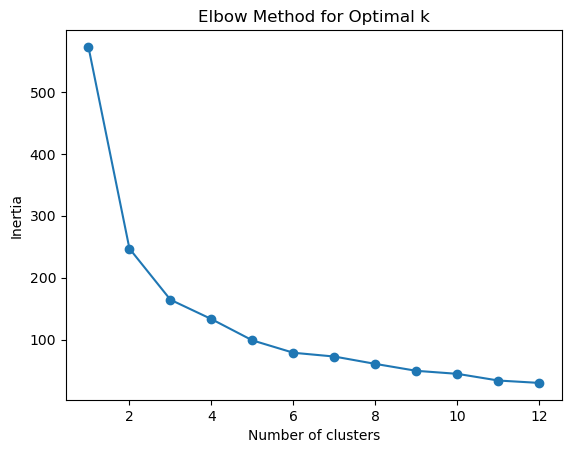

In [188]:
cluster_cols = [col for col in preprocessed_driver_data.columns if "remainder__" not in col]

n_clusters = 12
inertias = []
for cluster in range(1,n_clusters+1):
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    kmeans.fit(preprocessed_driver_data[cluster_cols])
    inertias.append(kmeans.inertia_)


plt.plot([i for i in range(1,n_clusters+1)], inertias, marker='o')
plt.xlabel("Number of clusters");
plt.ylabel("Inertia");
plt.title("Elbow Method for Optimal k");

In [193]:
best_n_clusters = 3
best_kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
preprocessed_driver_data['cluster'] = best_kmeans.fit_predict(preprocessed_driver_data[cluster_cols])

In [194]:
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(preprocessed_driver_data[cluster_cols])
preprocessed_driver_data['pca_one'] = pca_components[:,0]
preprocessed_driver_data['pca_two'] = pca_components[:,1]

In [195]:
pca.explained_variance_ratio_

array([0.68078045, 0.12239397])

In [196]:
dim_driver_number = DIMS.dim_driver_number()
dim_driver_number = dim_driver_number.sort_values(by='session_key', ascending=False).groupby('driver_number').agg(
    full_name = ('full_name', 'first')
).reset_index(drop=False)

In [197]:
preprocessed_driver_data = preprocessed_driver_data.merge(
    dim_driver_number,
    left_on = 'remainder__driver_number',
    right_on = 'driver_number',
    how = 'inner'
)

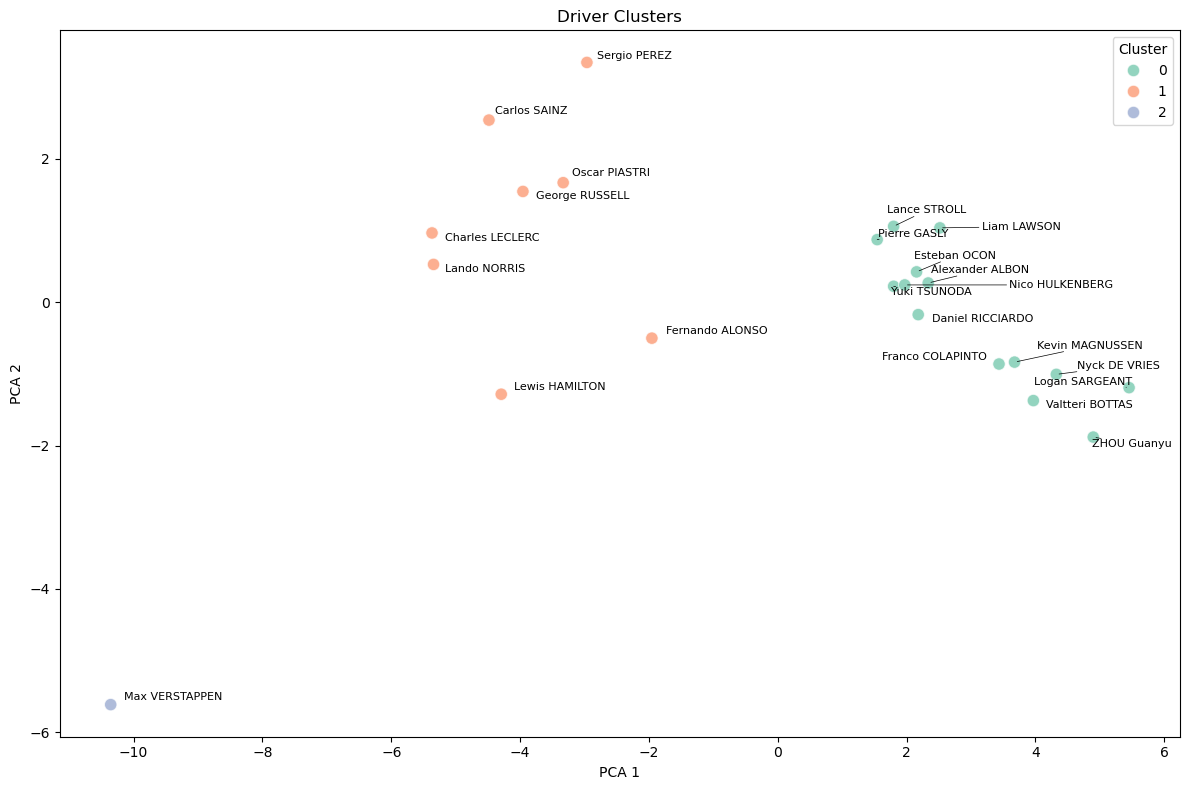

In [198]:

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=preprocessed_driver_data,
    x='pca_one',
    y='pca_two',
    hue='cluster',
    palette='Set2',
    alpha=0.7,
    s=80
)

texts = []
for _, row in preprocessed_driver_data.iterrows():
    texts.append(
        plt.text(
            row['pca_one'],
            row['pca_two'],
            str(row['full_name']),
            fontsize=8
        )
    )

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', lw=0.5)
)

plt.title("Driver Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


TODO: ADD CLUSTERS AS A FEATURE TO THE MODEL